<a href="https://colab.research.google.com/github/Olimaol/notebooks-deeprl/blob/main/solutions-output/07-Gym.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gym environments

## Installing gym

In this course, we will mostly address RL environments available in the **OpenAI Gym** framework:test

<https://gym.openai.com>

It provides a multitude of RL problems, from simple text-based problems with a few dozens of states (Gridworld, Taxi) to continuous control problems (Cartpole, Pendulum) to Atari games (Breakout, Space Invaders) to complex robotics simulators (Mujoco):

<https://gym.openai.com/envs>

However, `gym` is not maintained by OpenAI anymore since September 2022. We will use instead the `gymnasium` library maintained by the Farama foundation, which will keep on maintaining and improving the library.

<https://gymnasium.farama.org/>

You can install gymnasium and its dependencies we need in our exercise using:

```bash
pip install gymnasium pygame swig
pip install moviepy==1.0.3
```

For this exercise and the following, we will focus on simple environments whose installation is straightforward: toy text and classic control. More complex environments based on Atari games or the Mujoco physics simulator are described in the last (optional) section of this notebook, as they require additional dependencies. Running the next cell in colab should allow you to run the simplest environments:

In [1]:
# This cell automatically installs the dependencies if you run this notebook in Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install -U gymnasium pygame swig
    !pip install -U moviepy==1.0.3
    !pip install gymnasium[box2d]


Usually, `gym` can open graphical windows for visualizing the environments. This doesn't work in colab, as it is not possible in the browser. Therefore, in our exercise we will use a workaround using the `GymRecorder` class defined in the next cell, allowing to produce videos which can be displayed in the notebook.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

import gymnasium as gym
print("gym version:", gym.__version__)

from moviepy.editor import ImageSequenceClip, ipython_display
from IPython.display import Image, display

class GymRecorder(object):
    """
    Simple wrapper over moviepy to generate a .gif with the frames of a gym environment.
    
    The environment must have the render_mode `rgb_array_list`.
    """
    def __init__(self, env):
        self.env = env
        self._frames = []

    def record(self, frames):
        "To be called at the end of an episode."
        for frame in frames:
            self._frames.append(np.array(frame))

    def make_video(self, filename, show=True):
        "Generates the gif video."
        directory = os.path.dirname(os.path.abspath(filename))
        if not os.path.exists(directory):
            os.mkdir(directory)
        self.clip = ImageSequenceClip(list(self._frames), fps=self.env.metadata["render_fps"])
        self.clip.write_gif(filename, fps=self.env.metadata["render_fps"], loop=0)
        del self._frames
        self._frames = []
        if show:
            display(Image(filename=filename))

gym version: 1.2.1


## Interacting with an environment

A gym environment is created using:

```python
env = gym.make('CartPole-v1', render_mode="human")
```

where 'CartPole-v1' should be replaced by the environment you want to interact with. The following cell lists the environments available to you (including the different versions). But some of them need additional dependencies for rendering.

In [3]:
for env in gym.envs.registry.items():
    print(env[0])

CartPole-v0
CartPole-v1
MountainCar-v0
MountainCarContinuous-v0
Pendulum-v1
Acrobot-v1
phys2d/CartPole-v0
phys2d/CartPole-v1
phys2d/Pendulum-v0
LunarLander-v3
LunarLanderContinuous-v3
BipedalWalker-v3
BipedalWalkerHardcore-v3
CarRacing-v3
Blackjack-v1
FrozenLake-v1
FrozenLake8x8-v1
CliffWalking-v1
CliffWalkingSlippery-v1
Taxi-v3
tabular/Blackjack-v0
tabular/CliffWalking-v0
Reacher-v2
Reacher-v4
Reacher-v5
Pusher-v2
Pusher-v4
Pusher-v5
InvertedPendulum-v2
InvertedPendulum-v4
InvertedPendulum-v5
InvertedDoublePendulum-v2
InvertedDoublePendulum-v4
InvertedDoublePendulum-v5
HalfCheetah-v2
HalfCheetah-v3
HalfCheetah-v4
HalfCheetah-v5
Hopper-v2
Hopper-v3
Hopper-v4
Hopper-v5
Swimmer-v2
Swimmer-v3
Swimmer-v4
Swimmer-v5
Walker2d-v2
Walker2d-v3
Walker2d-v4
Walker2d-v5
Ant-v2
Ant-v3
Ant-v4
Ant-v5
Humanoid-v2
Humanoid-v3
Humanoid-v4
Humanoid-v5
HumanoidStandup-v2
HumanoidStandup-v4
HumanoidStandup-v5
GymV21Environment-v0
GymV26Environment-v0


The `render_mode` argument defines how you will see the environment:

* `None` (default): allows to train a DRL algorithm without wasting computational resources rendering it.
* `rgb_array_list`: allows to get numpy arrays corresponding to each frame. Will be useful when generating videos.
* `ansi`: string representation of each state. Only available for the "Toy text" environments.
* `human`: graphical window displaying the environment live.

The main interest of gym(nasium) is that all problems have a common interface defined by the class `gym.Env`. There are only three methods that have to be used when interacting with an environment:

* `state, info = env.reset()` restarts the environment and returns an initial state $s_0$.

* `state, reward, terminal, truncated, info = env.step(action)` takes an action $a_t$ and returns:
    * the new state $s_{t+1}$, 
    * the reward $r_{t+1}$, 
    * two boolean flags indicating whether the current state is terminal (won/lost) or truncated (timeout),
    * a dictionary containing additional info for debugging (you can ignore it most of the time).

* `env.render()` displays the current state of the MDP. When the render mode is set to `rgb_array_list` or `human`, it does not even have to called explicitly (since gym 0.25).

With this interface, we can interact with the environment in a standardized way:

* We first create the environment.
* For a fixed number of episodes:
    * We pick an initial state with `reset()`.
    * Until the episode is terminated:
        * We select an action using our RL algorithm or randomly.
        * We take that action (`step()`), observe the new state and the reward.
        * We go into the new state.

The following code shows how to interact with the CartPole environment with human rendering using a random policy. Note that it will only work on your computer, not in colab.

```python
env = gym.make('CartPole-v1', render_mode="human")

for episode in range(10):
    state, info = env.reset()
    done = False
    while not done:
        # Select an action randomly
        action = env.action_space.sample()
        
        # Sample a single transition
        next_state, reward, terminal, truncated, info = env.step(action)
        
        # Go in the next state
        state = next_state

        # End of the episode
        done = terminal or truncated

env.close()
```

In this exercise, we will either not render the environment or use the rendering mode `rgb_array_list` and create and display videos using a `GymRecorder` object.

```python
recorder = GymRecorder(env)
```

At the end of each episode, you tell the recorder to record all frames generated during the episode. You can get these frames using the `env.render()` method. The frames returned by `env.render()` are (width, height, 3) numpy arrays which are accumulated by the environment during the episode and flushed when `env.reset()` is called.

```python
recorder.record(env.render())
```

You can then generate a gif at the end of the simulation with:

```python
recorder.make_video('videos/CartPole-v1.gif')
```

By default the gif is displayed automatically.

MoviePy - Building file videos/CartPole-v1.gif with imageio.


t:   0%|          | 0/229 [00:00<?, ?it/s, now=None]

t:  81%|████████  | 186/229 [00:00<00:00, 1856.03it/s, now=None]

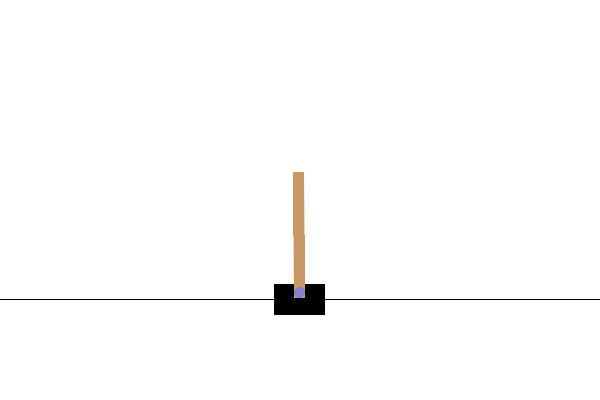

In [4]:
env = gym.make('CartPole-v1', render_mode="rgb_array_list")
recorder = GymRecorder(env)

for episode in range(10):
    state, info = env.reset()

    done = False
    while not done:
        # Select an action randomly
        action = env.action_space.sample()
        
        # Sample a single transition
        next_state, reward, terminal, truncated, info = env.step(action)
        
        # Go in the next state
        state = next_state

        # End of the episode
        done = terminal or truncated

    # Record at the end of the episode    
    recorder.record(env.render())

recorder.make_video('videos/CartPole-v1.gif')

Each environment defines its state space (`env.observation_space`) and action space (`env.action_space`). 

State and action spaces can either be :

* discrete (`gym.spaces.Discrete(nb_states)`), with states being an integer between 0 and `nb_states` -1.

* feature-based (`gym.spaces.Box(low=0, high=255, shape=(SCREEN_HEIGHT, SCREEN_WIDTH, 3))`) for pixel frames.

* continuous. Example for two joints of a robotic arm limited between -180 and 180 degrees:

```python
gym.spaces.Box(-180.0, 180.0, (2, ))
```

You can sample a state or action randomly from these spaces:

In [5]:
action_space = gym.spaces.Box(-180.0, 180.0, (2, ))
action = action_space.sample()
print(action)

[  14.260818 -117.74657 ]




Sampling the action space is particularly useful for exploration. We use it here to perform random (but valid) actions:

```python
action = env.action_space.sample()
```



**Q:** Create a method `random_interaction(env, number_episodes, recorder=None)` that takes as arguments:

* The environment.
* The number of episodes to be performed.
* An optional `GymRecorder` object that may record the frames of the environment if it is not None (`if renderer is not None:`). Otherwise, do not nothing.

The method should return the list of undiscounted returns ($\gamma=1$, i.e. just the sum of rewards obtained during each episode) for all episodes.

In [6]:
# Solution:
def random_interaction(env, number_episodes, recorder=None):

    returns = []

    # Sample episodes
    for episode in range(number_episodes):

        # Sample the initial state
        state, info = env.reset()

        return_episode = 0.0
        done = False
        while not done:

            # Select an action randomly
            action = env.action_space.sample()
        
            # Sample a single transition
            next_state, reward, terminal, truncated, info = env.step(action)

            # Update the return
            return_episode += reward
        
            # Go in the next state
            state = next_state

            # End of the episode
            done = terminal or truncated

        # Record at the end of the episode
        if recorder is not None:
            recorder.record(env.render())

        returns.append(return_episode)

    return returns


**Q:** Use that method to visualize some of the available simple environments for a few episodes, e.g.:

* CartPole-v1
* MountainCar-v0
* Pendulum-v1
* Acrobot-v1
* LunarLander-v2
* BipedalWalker-v3
* CarRacing-v2
* Blackjack-v1
* FrozenLake-v1
* CliffWalking-v0
* Taxi-v3

Also plot the obtained returns to see how they vary over the episodes. 

If you managed to install more complex dependencies (e.g. for mujoco and atari, see end of notebook), feel free to visualize them too. 

In [7]:
# Solution
def simple_plot_returns(returns, envname):
    plt.figure(figsize=(10, 6))
    plt.plot(returns)
    plt.title(envname)
    plt.xlabel("Episodes")
    plt.ylabel("Return")
    plt.show()

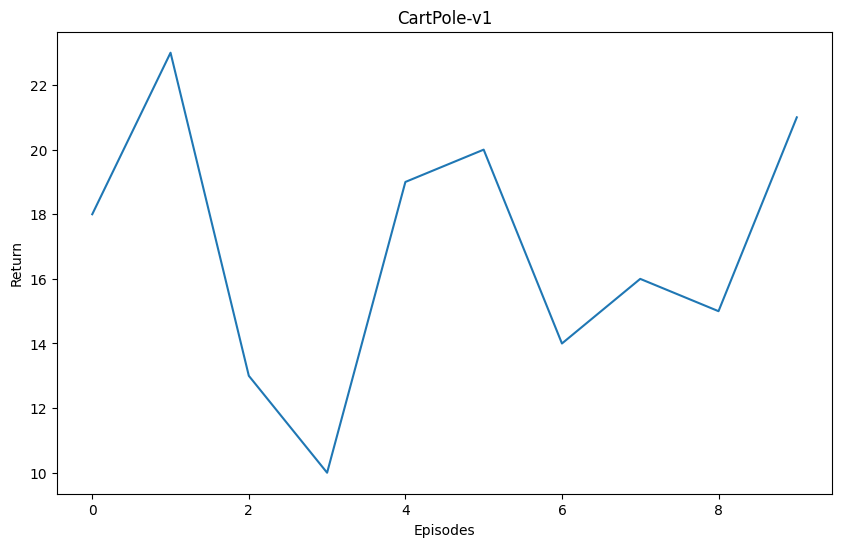

MoviePy - Building file videos/CartPole-v1.gif with imageio.


t:   0%|          | 0/179 [00:00<?, ?it/s, now=None]

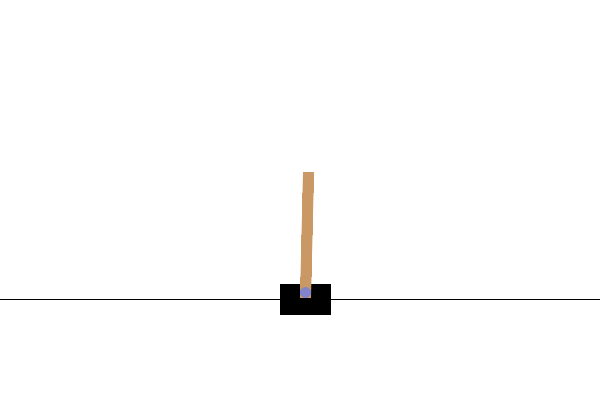

In [8]:
# Solution:
envname = 'CartPole-v1'
env = gym.make(envname, render_mode="rgb_array_list")
recorder = GymRecorder(env)
returns = random_interaction(env, 10, recorder)
simple_plot_returns(returns, envname)
recorder.make_video(f"videos/{envname}.gif")

## Creating your own environment

### Random environment

You can create your own environment using the gym interface:

<https://gymnasium.farama.org/tutorials/environment_creation/>

Here is an example of a dummy environment with discrete states and actions, where the transition probabilities and rewards are completely random:

In [9]:
class RandomEnv(gym.Env):
    "Random discrete environment that does nothing."
    
    metadata = {"render_modes": ["ansi"], "render_fps": 1}

    def __init__(self, nb_states, nb_actions, max_episode_steps=10, render_mode="ansi"):

        self.nb_states = nb_states
        self.nb_actions = nb_actions
        self.max_episode_steps = max_episode_steps
        self.render_mode = render_mode

        # State space, can be discrete or continuous.
        self.observation_space = gym.spaces.Discrete(nb_states)
        
        # Action space, can be discrete or continuous.
        self.action_space = gym.spaces.Discrete(nb_actions)    

        # Reset
        self.reset()


    def reset(self, seed=None, options=None):

        # Re-initialize time
        self.current_step = 0
        
        # Sample one state randomly 
        self.state = self.observation_space.sample()
        
        return self.state, {}

    def step(self, action):

        # Random transition to another state
        self.state = self.observation_space.sample() 
        
        # Random reward
        reward = np.random.uniform(0, 1, 1)[0] 
        
        # Terminate the episode after 10 steps
        terminal = False 
        truncated = False

        self.current_step +=1
        if self.current_step % self.max_episode_steps == 0:
            truncated = True 

        info = {} # No info

        return self.state, reward, terminal, truncated, info


    def render(self):
        if self.render_mode == "ansi":
            description = "Step " + str(self.current_step) + ": state " + str(self.state)
            return description
        return None


The different methods should be quite self-explanatory.

`metadata` defines which render modes are available for this environment (here only the text mode "ansi").

The constructor accepts the size of the state and action spaces as arguments, the duration of the episode and the render mode. 

`reset()` samples an initial state randomly.

`step()` ignores the action, samples a new state and a reward, and truncates an episode after `max_episode_steps`.

`render()` returns a string with the current state.

**Q:** Interact with the random environment for a couple of episodes.

As the mode is `ansi` (text-based), you will need to print the string returned by `render()` after each step:

```python
while not done:

    action = env.action_space.sample()
    
    next_state, reward, terminal, truncated, info = env.step(action)

    print(env.render())
```

In [10]:
# Solution:
# Create the environment
env = RandomEnv(nb_states=10, nb_actions=4)

# Sample episodes
for episode in range(2):

    print("Episode", episode)

    # Sample the initial state
    state, info = env.reset()

    # Render the initial state
    print(env.render())

    # Episode
    return_episode = 0.0
    done = False
    while not done:
        # Select an action randomly
        action = env.action_space.sample()
        
        # Sample a single transition
        next_state, reward, terminal, truncated, info = env.step(action)
        
        # Go in the next state
        state = next_state

        # Update return
        return_episode += reward

        # Render the current state
        print(env.render())

        # End of the episode
        done = terminal or truncated
    
    print("Return of the episode:", return_episode)
    print('-'*10)


Episode 0
Step 0: state 3
Step 1: state 6
Step 2: state 8
Step 3: state 5
Step 4: state 1
Step 5: state 2
Step 6: state 3
Step 7: state 9
Step 8: state 7
Step 9: state 5
Step 10: state 3
Return of the episode: 4.618147224005554
----------
Episode 1
Step 0: state 2
Step 1: state 3
Step 2: state 5
Step 3: state 5
Step 4: state 5
Step 5: state 7
Step 6: state 8
Step 7: state 7
Step 8: state 9
Step 9: state 0
Step 10: state 4
Return of the episode: 4.550401810505547
----------


### Recycling robot

**Q:** Create a `RecyclingRobot` gym-like environment using last week's exercise.

The parameters `alpha`, `beta`, `r_wait` and `r_search` should be passed to the constructor of the environment and saved as attributes.

The state space is discrete, with two states `high` and `low` which will have indices 0 and 1. The three discrete actions `search`, `wait` and `recharge` have indices 0, 1, and 2.

The initial state of the MDP (`reset()`) should be the high state.

The `step()` should generate transitions according to the dynamics of the MDP. Depending on the current state and the chosen action, make a transition to another state. For the actions `search` and `wait`, sample the reward from the normal distribution with mean `r_search` (resp. `r_wait`) and variance 0.5. 

If the random agent selects `recharge` in `high`, do nothing (next state is high, reward is 0).

Rendering is just printing the current state. There is nothing to close, so you do not even need to redefine the function.

Although the recycling robot is a continuing task, limit the number of steps per episode to 10, as in the the previous random environment.

Interact randomly with the MDP for several episodes and observe the returns. 

In [11]:
# Solution:
class RecyclingRobot(gym.Env):
    "Recycling robot environment."

    metadata = {"render_modes": ["ansi"], "render_fps": 1}

    def __init__(self, alpha, beta, r_search, r_wait, max_episode_steps=10, render_mode="ansi"):
        
        # Store parameters
        self.alpha = alpha
        self.beta = beta
        self.r_search = r_search
        self.r_wait = r_wait
        self.max_episode_steps = max_episode_steps
        self.render_mode = render_mode
        
        # State space, can be discrete or continuous.
        self.observation_space = gym.spaces.Discrete(2)        
        self.states =  ['high', 'low']
        
        # Action space, can be discrete or continuous.
        self.action_space = gym.spaces.Discrete(3)  
        self.actions = ['search', 'wait', 'recharge']  

        # Reset
        self.reset()
    
    def reset(self, seed=None, options=None):
        
        # Re-initialize time
        self.current_step = 0

        # Start in the high state
        self.state = 0
        
        return self.state, {}
    
    def step(self, action):
        
        if self.state == 0: # high
            if action == 0: # search
                p = np.random.rand()
                if p < self.alpha:
                    self.state = 0 # high
                else:
                    self.state = 1 # low
                self.reward = float(np.random.normal(self.r_search, 0.5, 1))
            elif action == 1: # wait
                self.state = 0 # high
                self.reward = float(np.random.normal(self.r_wait, 0.5, 1))
            elif action == 2: # recharge
                self.state = 0 # high
                self.reward = 0.0
                
        elif self.state == 1: # low
            if action == 0: # search
                p = np.random.rand()
                if p < self.beta:
                    self.state = 1 # low
                    self.reward = float(np.random.normal(self.r_search, 0.5, 1))
                else:
                    self.state = 0 # high
                    self.reward = -3.0
            elif action == 1: # wait
                self.state = 1 # low
                self.reward = float(np.random.normal(self.r_wait, 0.5, 1))
            elif action == 2: # recharge
                self.state = 0 # high
                self.reward = 0.0
        
        terminal = False
        truncated = False
        self.current_step +=1
        if self.current_step % self.max_episode_steps == 0:
            truncated = True 

        info = {} # No info

        return self.state, self.reward, terminal, truncated, info

    def render(self):
        
        if self.render_mode == "ansi":
            description = "Step " + str(self.current_step) + ": state " + self.states[self.state]
            return description
            
        return None

In [12]:
# Solution:
# Create the environment
env = RecyclingRobot(alpha=0.3, beta=0.2, r_search=6, r_wait=2)

# Sample episodes
for episode in range(10):

    print("Episode:", episode)

    # Sample the initial state
    state, info = env.reset()
    print(env.render())

    return_episode = 0.0
    done = False
    while not done:

        # Select an action randomly
        action = env.action_space.sample()
        
        # Sample a single transition
        next_state, reward, terminal, truncated, info = env.step(action)
        
        print(env.states[state], "+", env.actions[action], "->", env.states[next_state], ":", reward)
        
        # Go in the next state
        state = next_state

        # Update return
        return_episode += reward

        # Render the current state
        print(env.render())

        # End of the episode
        done = terminal or truncated
    
    print("Return of the episode:", return_episode)
    print('-'*10)

Episode: 0
Step 0: state high
high + recharge -> high : 0.0
Step 1: state high
high + recharge -> high : 0.0
Step 2: state high
high + recharge -> high : 0.0
Step 3: state high
high + search -> high : 5.566323067823818
Step 4: state high
high + search -> low : 5.9007177036767215
Step 5: state low
low + recharge -> high : 0.0
Step 6: state high
high + wait -> high : 2.5235206612024554
Step 7: state high
high + wait -> high : 1.816934165647863
Step 8: state high
high + wait -> high : 2.28546998150958
Step 9: state high
high + search -> low : 6.272123144275655
Step 10: state low
Return of the episode: 24.365088724136093
----------
Episode: 1
Step 0: state high
high + wait -> high : 1.7244437914940995
Step 1: state high
high + wait -> high : 2.2418779816188317
Step 2: state high
high + search -> high : 6.022399625757923
Step 3: state high
high + search -> low : 5.105653006247996
Step 4: state low
low + search -> low : 5.504364854916949
Step 5: state low
low + search -> high : -3.0
Step 6: 

### Random agent

To be complete, let's implement the random agent as a class. The class should look like:

```python
class RandomAgent:
    """
    Random agent exploring uniformly the environment.
    """
    
    def __init__(self, env):
        self.env = env
    
    def act(self, state):
        "Returns a random action by sampling the action space."
        action = # TODO
        return action
    
    def update(self, state, action, reward, next_state):
        "Updates the agent using the transition (s, a, r, s')."
        pass
    
    def train(self, nb_episodes, render=False):
        "Runs the agent on the environment for nb_episodes. Returns the list of obtained returns."
        
        # List of returns
        returns = []

        # TODO
            
        return returns
```

The environment is passed to the constructor. `act(state)` should sample a random action. `update(state, action, reward, next_state)` does nothing for the random agent (`pass` is a Python command doing nothing), but we will implement it in the next exercises. 

`train(nb_episodes, render)` implements the interaction loop between the agent and the environment for a fixed number of episodes. It should return the list of obtained returns. `render` defines whether you print the state at each step or not.

**Q:** Implement the random agent and have it interact with the environment for a fixed number of episodes.

In [13]:
# Solution:
class RandomAgent:
    """
    Random agent exploring uniformly the environment.
    """
    
    def __init__(self, env):
        self.env = env
    
    def act(self, state):
        "Returns a random action by sampling the action space."
        return self.env.action_space.sample()
    
    def update(self, state, action, reward, next_state):
        "Updates the agent using the transition (s, a, r, s')."
        pass
    
    def train(self, nb_episodes, render=False):
        "Runs the agent on the environment for nb_episodes. Returns the list of obtained rewards."
        # List of returns
        returns = []

        for episode in range(nb_episodes):
            if render:
                print("Episode:", episode)

            # Sample the initial state
            state, info = self.env.reset()
            if render:
                print(self.env.render())

            return_episode = 0.0
            done = False
            while not done:

                # Select an action randomly
                action = self.act(state)
                
                # Sample a single transition
                next_state, reward, terminal, truncated, info = self.env.step(action)
                
                # Go in the next state
                state = next_state

                # Update return
                return_episode += reward

                # Render the current state
                if render:
                    print(env.render())

                # End of the episode
                done = terminal or truncated
            
            returns.append(return_episode)

        return returns

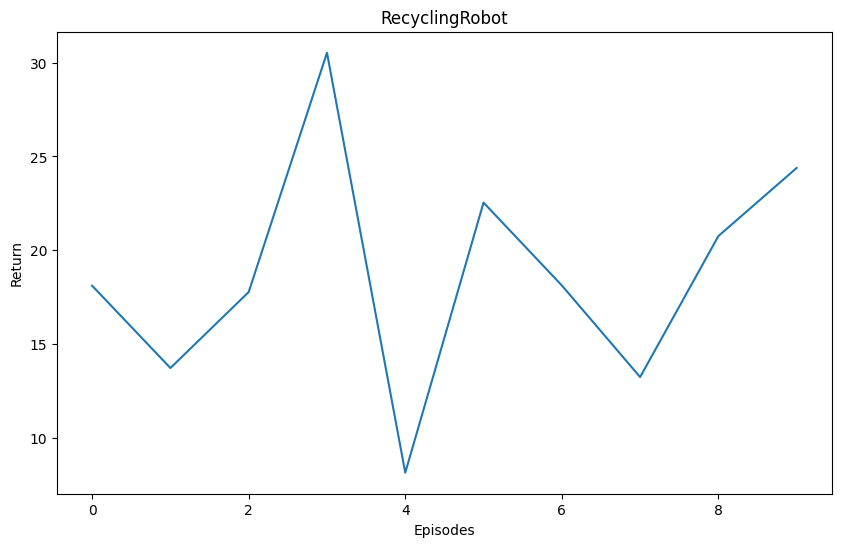

In [14]:
# Solution:
# Create the environment
env = RecyclingRobot(alpha=0.3, beta=0.2, r_search=6, r_wait=2)

# Creating the random agent
agent = RandomAgent(env)

# Train the agent for 10 episodes
returns = agent.train(10)


# Plot the rewards
simple_plot_returns(returns, "RecyclingRobot")

That's it! We now "only" need to define classes for all the sampling-based RL algorithms (MC, TD, deep RL) and we can interact with any environment with a single line!

## Mujoco and Atari environments

Note: both mujoco and atari environments will not work on colab. 

You may have to install non-Python packages on your computer, such as openGL. A lot of debugging in sight...

The environments should work under Linux and MacOS, but I am not sure about windows. 

### Mujoco

To install the mujoco environments of gymnasium, this should work:

```bash
pip install mujoco
pip install "gymnasium[mujoco]"
```

Interaction should work as usual. See all environments here: <https://gymnasium.farama.org/environments/mujoco/>

```python
envname = 'Walker2d-v4'
env = gym.make(envname, render_mode="rgb_array_list")
recorder = GymRecorder(env)
returns = random_interaction(env, 10, recorder)
simple_plot_returns(returns, envname)
recorder.make_video(f"videos/{envname}.gif")
```

### Atari

The atari games are available as binary ROM files, which have to be downloaded separately. The AutoROM package can do that for you:  <https://github.com/Farama-Foundation/AutoROM>

```bash
pip install autorom
AutoROM --accept-license
```

You can then install the atari submodules of gym (in particular ale_py):

```bash
pip install "gymnasium[atari]"
```

Check out the list of Atari games here:  <https://gymnasium.farama.org/environments/atari/>

```python
import ale_py
gym.register_envs(ale_py)
envname= 'ALE/Breakout-v5'
env = gym.make(envname, render_mode="rgb_array_list")
recorder = GymRecorder(env)
returns = random_interaction(env, 10, recorder)
simple_plot_returns(returns, envname)
recorder.make_video(f"videos/{envname}.gif")
```